# COMP 551 — Assignment 2

Authors:
 - Bernier, Audréanne
 - Coull-Neveu, Ben
 - Trachsel-Bourbeau, Anjara

Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# define plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['legend.fancybox'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5

# set default save directory and parameters
SAVEDIR = './figures/'
os.makedirs(SAVEDIR, exist_ok=True)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

## Functions & Models

### Useful Functions

In [3]:
# sum of squared errors (SSE)
def SSE(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

# Defining y(x)
y = lambda x, err=0: np.log(x+1) * np.cos(x) + np.sin(2*x) + err


# Gaussian basis function
gaussian = lambda x, mu, sigma=1: np.exp(-((x-mu)/sigma)**2)



### Model Implementations

In [4]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        self.N= None # init N
        self.w = None # init w
        self.num_batches = None # batches for gradient descent
        self.loss = None
        self.loss_history = []
        self.w_history = []
        self.grad_history = []
        self.total_epochs = None

    @staticmethod
    def l2_loss(x, y, w):
      return np.mean((y - (x @ w))**2)

    def fit_analytical(self, x, y):
        """
        Fit the model using the analytical solution.
        """
        # Check shape of x
        if x.ndim == 1:
            x = x[:, None]  # add a dimension for the features
        N = x.shape[0]

        # Add bias term if needed
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])

        # Analytical weight solution using least squares
        self.w = np.linalg.lstsq(x, y, rcond=None)[0]

        # calculate loss for comparisons
        self.loss = LinearRegression.l2_loss(x, y, self.w)
        return self


    def fit_gd_minibatch(self, x, y, optimizer, num_batches=8):
        """
        Fit the model using mini-batch gradient descent.
        """
        # Check shape of x
        if x.ndim == 1:
            x = x[:, None]

        self.num_batches = num_batches

        # Add bias term if needed
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape

        # Define the gradient function
        def gradient(x, y, w):
            N_batch = x.shape[0]  # batch size
            yh = x @ w
            # grad = (x.T @ (yh - y)) / N_batch
            grad = np.dot(x.T, yh - y)/N_batch
            return grad

        # Run mini-batch GD
        w0 = np.zeros(D)  # initialize the weights to 0
        self.w = optimizer.run_minibatch(gradient,
                                         LinearRegression.l2_loss,
                                         x, y, w0,
                                         self.num_batches
                                         )  # run the optimizer to get the optimal weights

        self.loss = LinearRegression.l2_loss(x, y, self.w)
        self.loss_history = optimizer.loss_history
        self.w_history = optimizer.w_history
        self.grad_history = optimizer.grad_history
        self.total_epochs = optimizer.total_epochs
        return self


    def predict(self, x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w  # predict the y values
        return yh


    def __str__(self):
        return f'weights: {self.w}'

## Task 1: Linear Regression with Non-Linear Basis Functions

#### Data Generation & Non-Linear Basis Functions

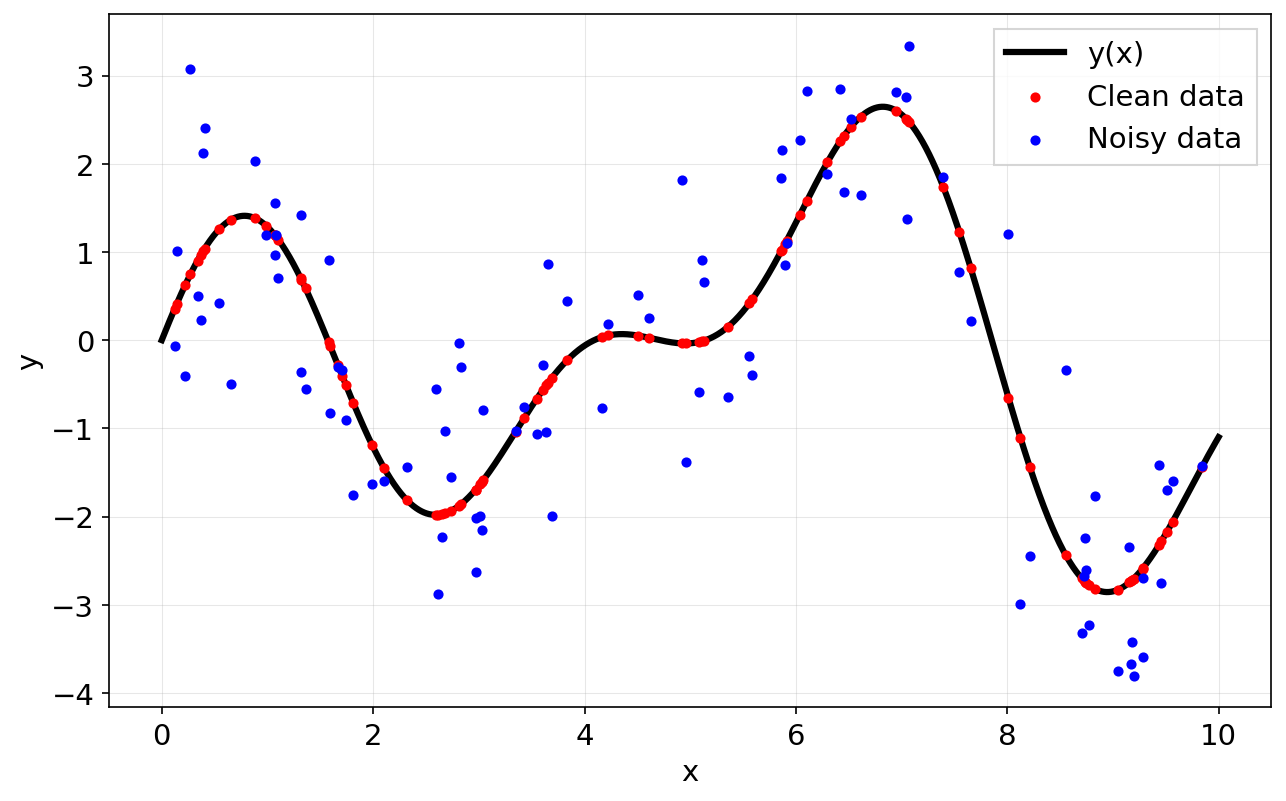

In [5]:
# -- 1. Generate data --
# generate data points
n = 100
x = np.sort(np.random.uniform(0, 10, n))
xs = np.sort(np.random.uniform(0, 10, n**2))
err = np.random.randn(n)

# plotting
plt.plot(xs, y(xs), c='k', lw=3, label='y(x)')
plt.scatter(x, y(x), c='r', s=15, zorder=5, label='Clean data')
plt.scatter(x, y(x, err), c='b', s=15, zorder=5, label='Noisy data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig(SAVEDIR + 'generated data.png')
plt.show()

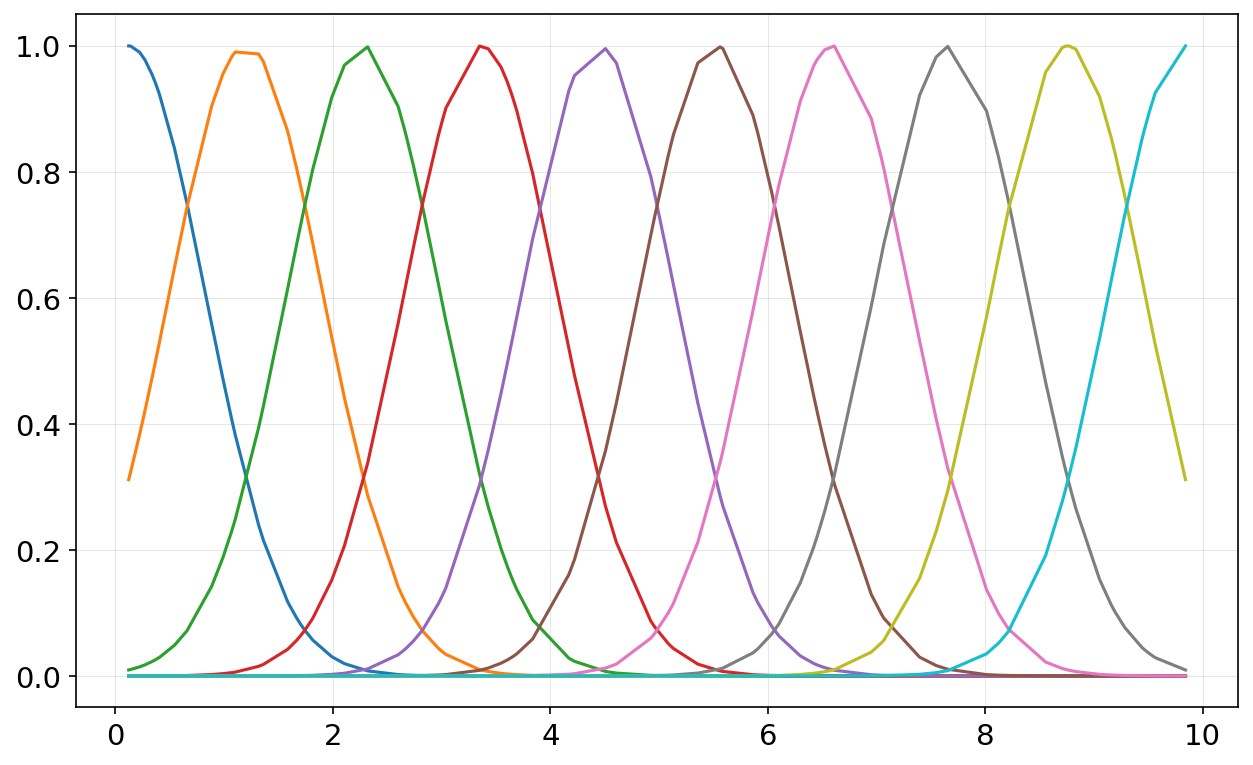

In [6]:
# -- 2. Non-linear basis --

# number of basis function D
D = 10

# generate means
bases = np.arange(0, D)
mu = np.min(x) + (np.max(x) - np.min(x))/(D-1) * bases
phi = gaussian(x[:,None], mu[None,:])

# plot gaussians
for d in range(D):
  plt.plot(x, phi[:,d])
  
plt.savefig(SAVEDIR + '10 gaussian bases.png')
plt.show()

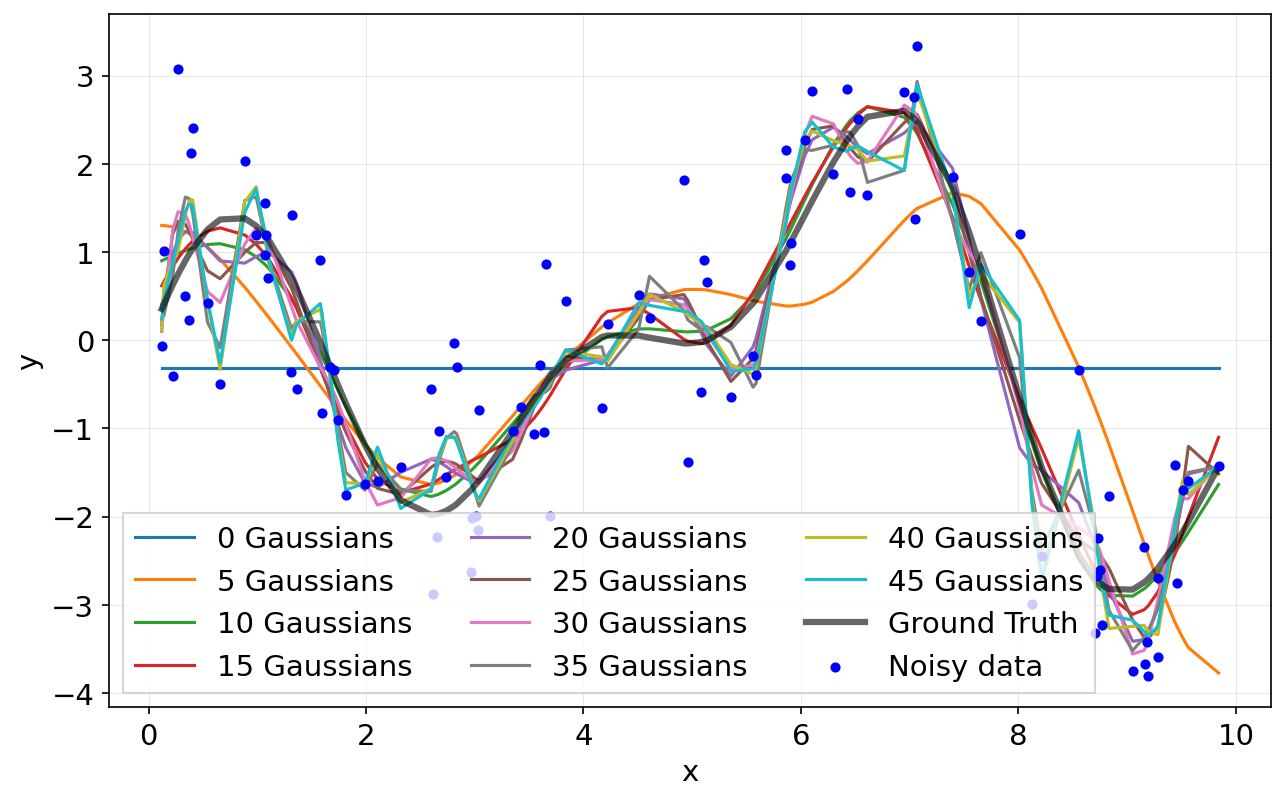

In [7]:
# -- 3. Model fitting
D = np.arange(0,45+1, 5)


plt.figure()
for d in D:
  model = LinearRegression()
  bases = np.arange(0, d)
  mu = np.min(x) + (np.max(x) - np.min(x))/(d-1) * bases
  phi = gaussian(x[:,None], mu[None,:])

  yh = model.fit_analytical(phi, y(x,err)).predict(phi)

  plt.plot(x, yh, label=f'{d} Gaussians')

plt.plot(x, y(x), c='k', lw=3, alpha=.6, label='Ground Truth')
plt.scatter(x, y(x, err), c='b', s=15, zorder=5, label='Noisy data')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(ncols=3)

plt.savefig(SAVEDIR + 'model fitting with various D.png')
plt.show()

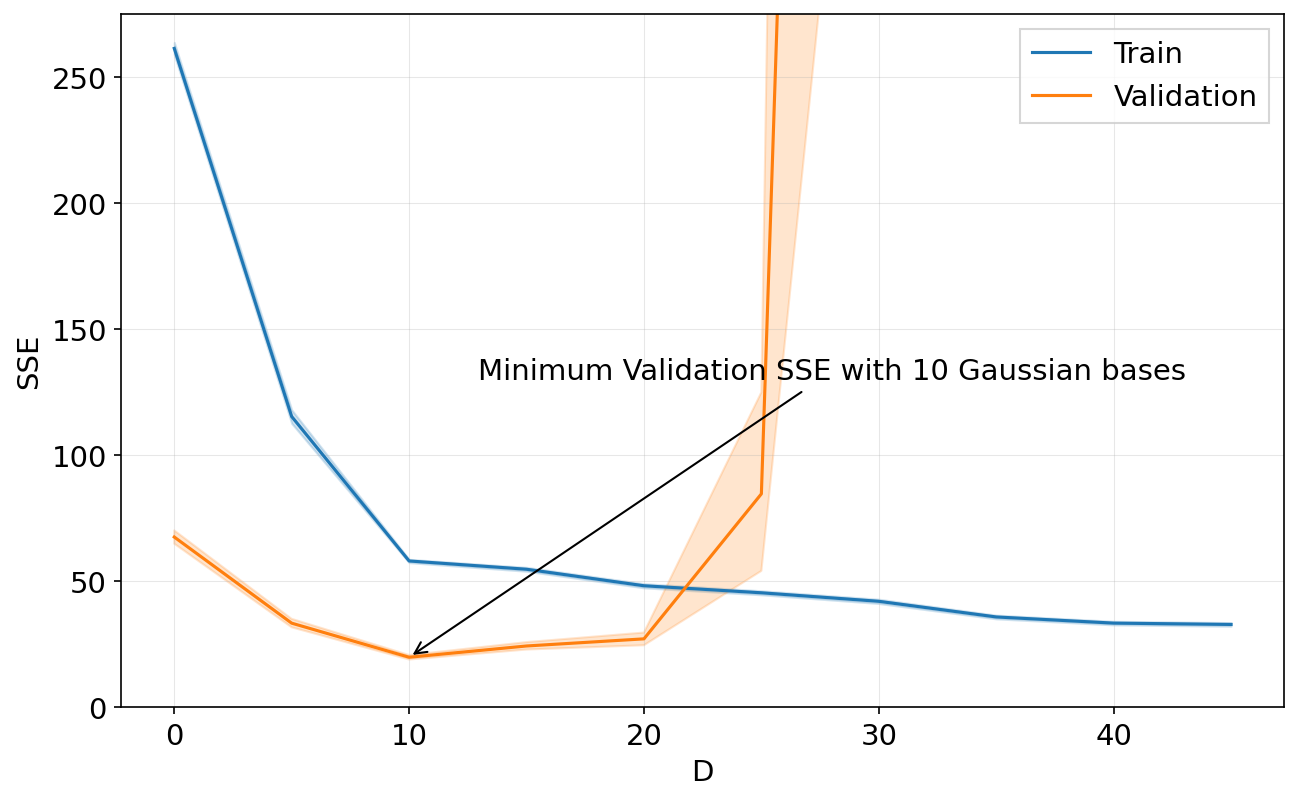

In [8]:
# -- 4. Model Selection

# train the models
# models = {}
# sse_train = []
# sse_val = []
results_list = []  # Collect results in a list instead of concatenating DataFrames
iterations = 128

for i in range(iterations):
  train_val_split = 0.8 # train/val split ratio
  trainsize = int(len(x)*train_val_split)

  # get the appropriate error for each datum
  np.random.seed(i)
  idx = np.random.choice(len(x), size=trainsize, replace=False)
  xtrain = x[idx]
  errtrain = err[idx]
  
  idx_val = np.setdiff1d(np.arange(len(x)), idx)
  xval = x[idx_val]
  errval = err[idx_val]
  
  # iterating over different model complexities
  D = np.arange(0,45+1, 5)
  for d in D:
    model = LinearRegression()
    bases = np.arange(0, d)
    mu = np.min(xtrain) + (np.max(xtrain) - np.min(xtrain))/(d-1) * bases
    phi = gaussian(xtrain[:,None], mu[None,:])

    yh = model.fit_analytical(phi, y(xtrain, errtrain)).predict(phi)

    sse_train = SSE(y(xtrain, errtrain), yh)
    sse_val = SSE(y(xval, errval), model.predict(gaussian(xval[:,None], mu[None,:])))
    
    results_list.append({
        'D': d, 
        'SSE_Train': sse_train, 
        'SSE_Val': sse_val, 
        'model': model,
        'iteration': i
    })

# create dataframe for convenient plotting
ssedf = pd.DataFrame(results_list)

# clean df to remove any infinite values
ssedf.replace([np.inf, -np.inf], np.nan, inplace=True)
ssedf.dropna(inplace=True)


# find smallest mean validation SSE
grouped = ssedf.groupby('D')['SSE_Val'].mean().reset_index()
valmin = grouped['SSE_Val'].min()
valmin_D = grouped['D'][np.where(grouped['SSE_Val'] == valmin)[0][0]]

plt.figure()

# plot with error bars being min and max
sns.lineplot(data=ssedf, x='D', y='SSE_Train', label='Train', errorbar=('ci', 95))
sns.lineplot(data=ssedf, x='D', y='SSE_Val', label='Validation', errorbar=('ci', 95))

# plt.plot(D, sse_train, label='Train')
# plt.plot(D, sse_val, label='Validation')
plt.annotate(f'Minimum Validation SSE with {valmin_D} Gaussian bases', (valmin_D, valmin), xytext=(28,130), ha='center', arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.xlabel('D')
plt.ylabel('SSE')

plt.ylim(0, 275)
plt.legend()
plt.savefig(SAVEDIR + 'train val sse vs D.png')
plt.show()

Best iteration for D=45 is 53 with SSE_val = 14.95622616522688. Setting as iteration for ALL model plots.


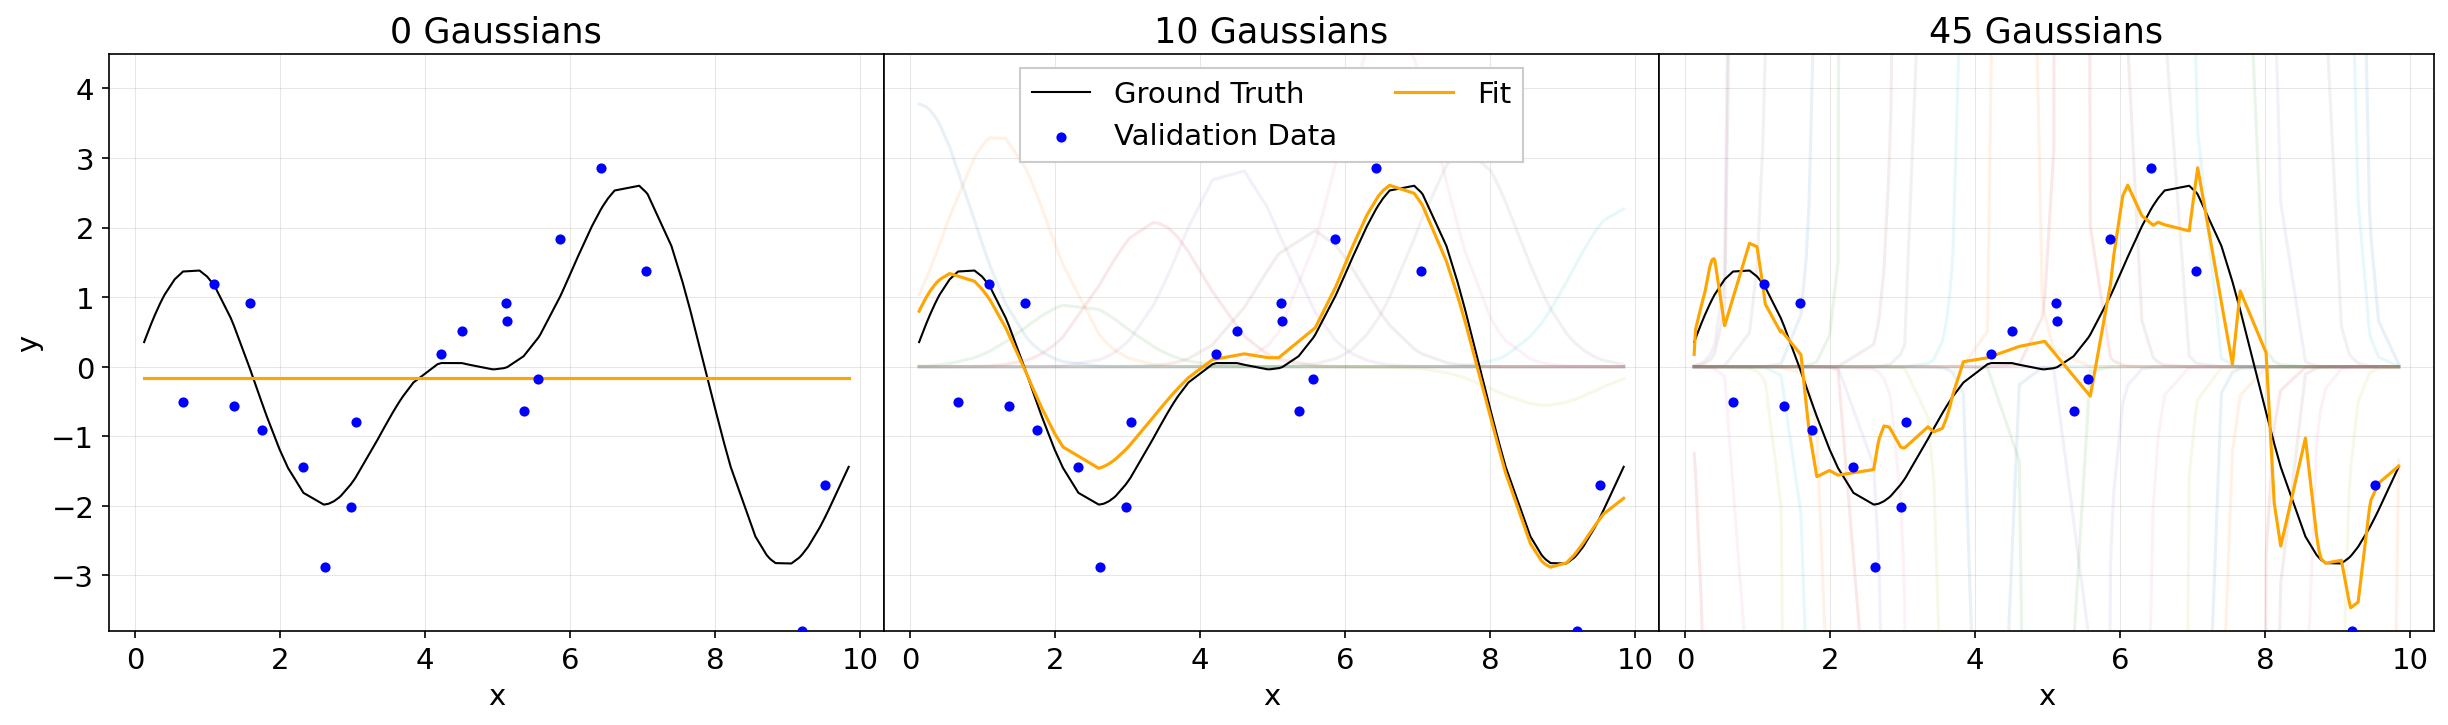

In [9]:
# -- 4. Continued...
best45model = ssedf.loc[ssedf['D'] == 45].sort_values(by='SSE_Val').iloc[0] # get best model for D=45
iteration = best45model['iteration'] # getting best iteration for D=45
print(f'Best iteration for D=45 is {iteration} with SSE_val = {best45model["SSE_Val"]}. Setting as iteration for ALL model plots.')

model0 = ssedf['model'][(ssedf['D'] == 0) & (ssedf['iteration'] == iteration)].values[0]
model10 = ssedf['model'][(ssedf['D'] == 10) & (ssedf['iteration'] == iteration)].values[0]
model45 = ssedf['model'][(ssedf['D'] == 45) & (ssedf['iteration'] == iteration)].values[0]

xtrain = np.sort(xtrain)
xval = np.sort(xval)

fig, [ax0, ax10, ax45] = plt.subplots(1, 3, figsize=(20,5), sharey=True)

# remove hspace
plt.subplots_adjust(wspace=0)
ax10.tick_params(left=False)
ax45.tick_params(left=False)

# 0 bases
ax0.set_title('0 Gaussians')
D = 0
bases = np.arange(0, D)
mu = np.min(xtrain) + (np.max(xtrain) - np.min(xtrain))/(D-1) * bases
phi = gaussian(xtrain[:,None], mu[None,:])

yh = model0.predict(phi)
# ax0.plot(xtrain, model0.w[-1]*np.ones_like(yh), label='Intercept')
ax0.plot(x, y(x), c='k', lw=1, label='Ground Truth')
ax0.scatter(xval, y(xval, errval), c='b', s=15, zorder=5, label='Validation Data')
ax0.plot(xtrain, yh, c='orange', label=f'Fit')
ax0.set_ylim(-3.8, 4.5)
ax0.set_ylabel('y')
ax0.set_xlabel('x')


# 10 gaussians
ax10.set_title('10 Gaussians')
D = 10
bases = np.arange(0, D)
mu = np.min(xtrain) + (np.max(xtrain) - np.min(xtrain))/(D-1) * bases
phi = gaussian(xtrain[:,None], mu[None,:])
yh = model10.predict(phi)
for d in range(D):
    ax10.plot(xtrain, model10.w[d]*phi[:,d], '-', alpha=.1)
# ax10.plot(xtrain, model10.w[-1]*np.ones_like(yh), label='Intercept')
ax10.plot(x, y(x), c='k', lw=1, label='Ground Truth')
ax10.scatter(xval, y(xval, errval), c='b', s=15, zorder=5, label='Validation Data')
ax10.plot(xtrain, yh, c='orange', label=f'Fit')
ax10.set_xlabel('x')
ax10.legend(loc='upper center', ncol=2, framealpha=1)


# 45 gaussians
ax45.set_title('45 Gaussians')
D = 45
bases = np.arange(0, D)
mu = np.min(xtrain) + (np.max(xtrain) - np.min(xtrain))/(D-1) * bases
phi = gaussian(xtrain[:,None], mu[None,:])
yh = model45.predict(phi)
for d in range(D):
    ax45.plot(xtrain, model45.w[d]*phi[:,d], '-', alpha=.1)
# ax45.plot(xtrain, model45.w[-1]*np.ones_like(yh), label='Intercept')
ax45.plot(x, y(x), c='k', lw=1, label='Ground Truth')
ax45.scatter(xval, y(xval, errval), c='b', s=15, zorder=5, label='Validation Data')
ax45.plot(xtrain, yh, c='orange', label=f'Fit')
ax45.set_xlabel('x')

plt.savefig(SAVEDIR + 'model fitting select D.png')
plt.show()

## Task 2: Bias-Variance Tradeoff with Multiple Fits

In [ ]:
""" 
Minimum Deliverables:
• Plots of bias-variance tradeoff figure and your explanation.
"""

## Task 3: Regularization with Cross-Validation

In [9]:
"""
Minimum Deliverables
• Plots showing train and validation errors vs. λ for both L1 and L2 regularization.
• Plots showing bias squared, variance, and (Bias)^2 + Variance,(Bias)^2 + Variance + noise_variance, as a function
    of λ, test error for both L1 and L2 regularization.
• Analysis of the results, explaining how the choice of λ affects the model performance in terms of bias and
    variance.
• Selection of the optimal λ for both L1 and L2 regularization.
"""

'\nMinimum Deliverables\n• Plots showing train and validation errors vs. λ for both L1 and L2 regularization.\n• Plots showing bias squared, variance, and (Bias)^2 + Variance,(Bias)^2 + Variance + noise_variance, as a function\n    of λ, test error for both L1 and L2 regularization.\n• Analysis of the results, explaining how the choice of λ affects the model performance in terms of bias and\n    variance.\n• Selection of the optimal λ for both L1 and L2 regularization.\n'

## Task 4: Effect of L1 and L2 Regularization on Loss

In [ ]:
"""
Minimum Deliverables
• Contour Plots: Contour plots of the loss function for L1 and L2 regularization with varying strengths.
• Optimization Paths: Plots showing the trajectory of gradient descent for different regularization strengths.
• Analysis: Based on the plots, provide observations about the impact of L1 and L2 regularization on the model’s weights and performance.
"""